# Analyse von Trinkgeldern mithilfe von Geo-Daten


- Step 1: Trinkgelder aus Text ziehen

- Step 2: Richtig formatieren, um am Ende ein DataFrame zu haben.

- Step 3: Mittels der Tabelle interessantes herausfinden
    -Zusammenhang Wochentag - Spendenrate
    -Verhältnis Bar zu App

- Step 4: Geo-Daten in die Analyse miteinbeziehen
    

In [1]:
import pandas as pd
from datetime import datetime
import os
import re
from folium.plugins import FastMarkerCluster
import numpy as np
import seaborn as sb
import matplotlib as plt

In [2]:
# Trinkgelder aus Textfile einlesen und formatieren.
# Achtung: Bestellungen wurden erst ab dem 19.11 gemessen!!!

# Textfile einlesen
with open('trinkgeld.txt', 'r') as f:
    lines = f.readlines()

# Leere Liste für die Daten
data = []

# Schleife für jede Zeile des Textfiles
for line in lines:
    # Teile die Zeile
    parts = line.split()
    bar = ""
    app = ""
    stunden = ""
    datum = ""
    bestellungen = ""
    for i, part in enumerate(parts):
        if part == "bar":
            bar = parts[i+1]
        elif part == "app":
            app = parts[i+1]
        elif part == "auf":
            stunden = parts[i+1]
        elif part == "am":
            datum = parts[i+1]
        elif part == "Bestellungen":
            bestellungen = parts[i+1]
    data.append([bar, app, stunden, datum, bestellungen])

# Dataframe generieren
df = pd.DataFrame(data, columns=['Bar', 'App', 'Stunden','Datum','Bestellungen'])

# Alle Kommata mit Punkten ersetzen, um zahlen als float nutzen zu können
df = df.apply(lambda x: x.str.replace(',', '.'))

# Columns in float umwandeln
df['Bar'] = df['Bar'].astype(float)
df['App'] = df['App'].astype(float)
df['Stunden'] = df['Stunden'].astype(float)

# Columns Bestellungen in Int umwandeln
df['Bestellungen'] = df['Bestellungen'].astype(int)


# Datum als Datetime-format
df['Datum'] = pd.to_datetime(df['Datum'], format="%d.%m.%y")
df['Datum'] = df['Datum'].dt.strftime('%d.%m.%y')
df = df.reindex(columns=['Datum','Stunden','Bestellungen','Bar','App'])


# Datum in datetime format und als index
df['Datum'] = pd.to_datetime(df['Datum'], format='%d.%m.%y')
df.set_index("Datum", inplace=True)

# Wochentage aus dem Datum herausziehen
df["Wochentag"] = df.index.day_name()

# Wochentage ins Deutsche übersetzen
weekday_map = {'Monday': 'Montag', 'Tuesday': 'Dienstag', 'Wednesday': 'Mittwoch',
               'Thursday': 'Donnerstag', 'Friday': 'Freitag', 'Saturday': 'Samstag', 'Sunday': 'Sonntag'}
df["Wochentag"] = df["Wochentag"].map(weekday_map)

# Wochentage nach links zum Datum
df.insert(0, "Wochentag", df.pop("Wochentag"))

# Bestellungen pro Stunde
df["Bestellungen_pro_Stunde"] = df["Bestellungen"] / df["Stunden"]
df.insert(3, "Bestellungen_pro_Stunde", df.pop("Bestellungen_pro_Stunde"))


# Trinkgeld gesamt einfügen
df["Trinkgeld_Gesamt"]=df["Bar"]+df["App"]

# Verhältnis App/Bar einfügen
df["Verhältnis_App/Bar"]=df["App"]/df["Bar"]
df.insert(7, "Verhältnis_App/Bar", df.pop("Verhältnis_App/Bar"))

# Trinkgeld pro Stunde einfügen
df["Trinkgeld_pro_Stunde"] = df["Trinkgeld_Gesamt"] / df["Stunden"]

# Trinkgeld pro Bestellung enfügen
df["Trinkgeld_pro_Bestellung"] = df["Trinkgeld_Gesamt"] / df["Bestellungen"]

# auf 2 Nachkommastellen runden
df = df.round(2)

df

,Wochentag,Stunden,Bestellungen,Bestellungen_pro_Stunde,Bar,App,Trinkgeld_Gesamt,Verhältnis_App/Bar,Trinkgeld_pro_Stunde,Trinkgeld_pro_Bestellung
Datum,,,,,,,,,,
2022-10-31,Montag,8.78,5,0.57,19.70,20.0,39.70,1.02,4.52,7.94
2022-11-02,Mittwoch,5.13,5,0.97,1.00,10.0,11.00,10.00,2.14,2.20
2022-11-03,Donnerstag,5.37,5,0.93,8.00,12.0,20.00,1.50,3.72,4.00
2022-11-04,Freitag,4.75,5,1.05,2.00,5.0,7.00,2.50,1.47,1.40
2022-11-07,Montag,5.53,5,0.90,9.50,6.0,15.50,0.63,2.80,3.10
2022-11-08,Dienstag,5.58,5,0.90,2.50,11.0,13.50,4.40,2.42,2.70
2022-11-09,Mittwoch,4.58,5,1.09,2.00,7.0,9.00,3.50,1.97,1.80
2022-11-10,Donnerstag,5.72,5,0.87,0.00,17.0,17.00,inf,2.97,3.40
2022-11-12,Samstag,4.52,5,1.11,0.00,9.0,9.00,inf,1.99,1.80


In [3]:
# Neues Dataframe ab dem 19.11.22, da erst ab dem Datum die Anzahl der Bestellungen getrackt worden sind :'(
df_old = df
df = df_old[13::]
df

,Wochentag,Stunden,Bestellungen,Bestellungen_pro_Stunde,Bar,App,Trinkgeld_Gesamt,Verhältnis_App/Bar,Trinkgeld_pro_Stunde,Trinkgeld_pro_Bestellung
Datum,,,,,,,,,,
2022-11-19,Samstag,5.30,21,3.96,6.00,14.0,20.00,2.33,3.77,0.95
2022-11-21,Montag,5.13,19,3.70,6.80,11.0,17.80,1.62,3.47,0.94
2022-11-22,Dienstag,4.73,12,2.54,1.00,3.0,4.00,3.00,0.85,0.33
2022-11-23,Mittwoch,4.50,15,3.33,2.00,7.0,9.00,3.50,2.00,0.60
2022-11-26,Samstag,5.97,13,2.18,2.00,8.0,10.00,4.00,1.68,0.77
2022-11-28,Montag,5.28,15,2.84,2.00,9.0,11.00,4.50,2.08,0.73
2022-11-29,Dienstag,4.35,10,2.30,2.30,6.0,8.30,2.61,1.91,0.83
2022-11-30,Mittwoch,4.57,7,1.53,10.00,13.0,23.00,1.30,5.03,3.29
2022-12-03,Samstag,7.98,23,2.88,18.00,16.0,34.00,0.89,4.26,1.48


In [4]:
# Wie verteilt sich das Trinkgeld auf die Wochentage?
df_wochen = df.groupby("Wochentag").mean().round(2)
df_wochen = df_wochen[['Bar', 'App', 'Trinkgeld_Gesamt', 'Trinkgeld_pro_Stunde', 'Trinkgeld_pro_Bestellung']]
df_wochen.reindex(['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Samstag'])

,Bar,App,Trinkgeld_Gesamt,Trinkgeld_pro_Stunde,Trinkgeld_pro_Bestellung
Wochentag,,,,,
Montag,2.66,10.00,12.66,2.46,0.83
Dienstag,3.26,4.40,7.66,1.49,0.70
Mittwoch,4.39,11.89,16.28,3.10,1.23
Donnerstag,6.04,9.20,15.24,2.71,1.16
Samstag,10.16,13.50,23.66,4.24,1.47


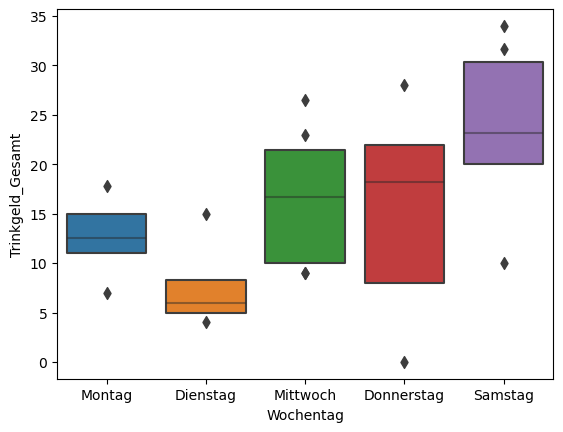

In [5]:
# Plotte eine Grafik, um das Trinkgeld je Wochentag anzuzeigen
ax = sb.boxenplot(x="Wochentag", y="Trinkgeld_Gesamt", data=df, order=["Montag", "Dienstag", "Mittwoch", "Donnerstag", "Samstag"])


In [6]:
# Stressigster Wochentag? Bzw. Anzahl der Bestellungen pro Schicht und pro Stunde.
df_wochen = df.groupby("Wochentag").mean().round(2)
df_wochen = df_wochen[['Stunden', 'Bestellungen', 'Bestellungen_pro_Stunde']]
df_wochen = df_wochen.reindex(['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Samstag'])

df_wochen

,Stunden,Bestellungen,Bestellungen_pro_Stunde
Wochentag,,,
Montag,5.15,15.40,2.98
Dienstag,5.47,11.80,2.17
Mittwoch,5.19,14.89,2.87
Donnerstag,5.43,12.80,2.28
Samstag,5.67,18.00,3.18


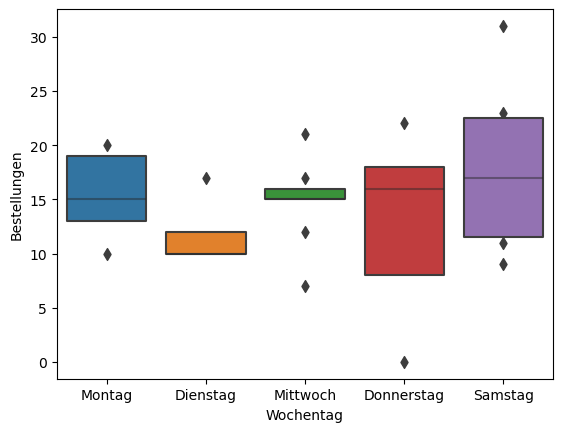

In [7]:
# Grafik zeigt Bestellungen pro Wochentag an
ax = sb.boxenplot(x="Wochentag", y="Bestellungen", data=df, order=["Montag", "Dienstag", "Mittwoch", "Donnerstag", "Samstag"])


In [8]:
# Hole die Listen für Distanz und zurückgelegte Steigung aus dem anderen Notebook
%store -r

In [20]:
# Erstelle ein neues df aus den Geo-Daten und der Spendentabelle, vereinige anschließend die beiden Dataframes
df1 = pd.DataFrame({'Datum': liste_time, 'Steigung': liste_elev, 'Distanz': liste_dist})
df1['Datum'] = pd.to_datetime(df1['Datum'], utc=True).dt.tz_convert(None)
df1['Datum'] = df1['Datum'].dt.date

df1 = df1.set_index('Datum')
df1.index = pd.to_datetime(df1.index)


In [11]:
# Kombiniere beide dfs
df = pd.merge(df, df1, on='Datum', how='outer')

In [12]:
# Gruppiere anhand der Wochentage. 
# Setze Trinkgeld und bei einer Schicht zurückgelegte Distanz, Steigung ins Verhältnis.
dfed = df.groupby('Wochentag')[['Trinkgeld_Gesamt', 'Steigung', 'Distanz']].mean()
dfed['Steigung_Meter_pro_1_Euro'] = dfed['Steigung'] / dfed['Trinkgeld_Gesamt']
dfed['Distanz_Meter_pro_1_Euro'] = dfed['Distanz'] / dfed['Trinkgeld_Gesamt']
dfed['Euro_pro_1_km'] =  dfed['Trinkgeld_Gesamt'] / (dfed['Distanz'] / 1000)


dfed = dfed.reindex(['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Samstag'])
dfed = dfed.round(2)
dfed

,Trinkgeld_Gesamt,Steigung,Distanz,Steigung_Meter_pro_1_Euro,Distanz_Meter_pro_1_Euro,Euro_pro_1_km
Wochentag,,,,,,
Montag,12.66,621.60,36916.24,49.10,2915.97,0.34
Dienstag,7.66,553.33,32597.42,72.24,4255.54,0.23
Mittwoch,16.28,585.56,35799.36,35.96,2198.53,0.45
Donnerstag,15.24,605.50,36197.42,39.73,2375.16,0.42
Samstag,23.66,565.83,33348.23,23.92,1409.58,0.71
